<a href="https://colab.research.google.com/github/nhahub/NHA-046/blob/Crop_Recommendation_weeks_3_4/Crop_recommendation_week_3%264.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dagshub
!pip install mlflow

# **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ML Libraries
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, precision_score, recall_score)

In [ ]:
# MLflow
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import dagshub

### **Load Dataset**

In [ ]:
df = pd.read_csv('/content/Crop_recommendation.csv')
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [ ]:
print(f"Shape: {df.shape}")
print(f"\nData types:")
df.info()

Shape: (2200, 8)

Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [ ]:
print(f"Statistical summary:")
df.describe()

Statistical summary:


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


There are no extreme values in the data

In [ ]:
print("Data quality check")
print(f"Missing values:\n{df.isna().sum()}")
print(f"\nDuplicate rows: {df.duplicated().sum()}")

Data quality check
Missing values:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

Duplicate rows: 0


Dataset is clean with no missing values or duplicates

# **Exploratory Data Analysis (EDA)**

In [ ]:
# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

Target distribution
label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64


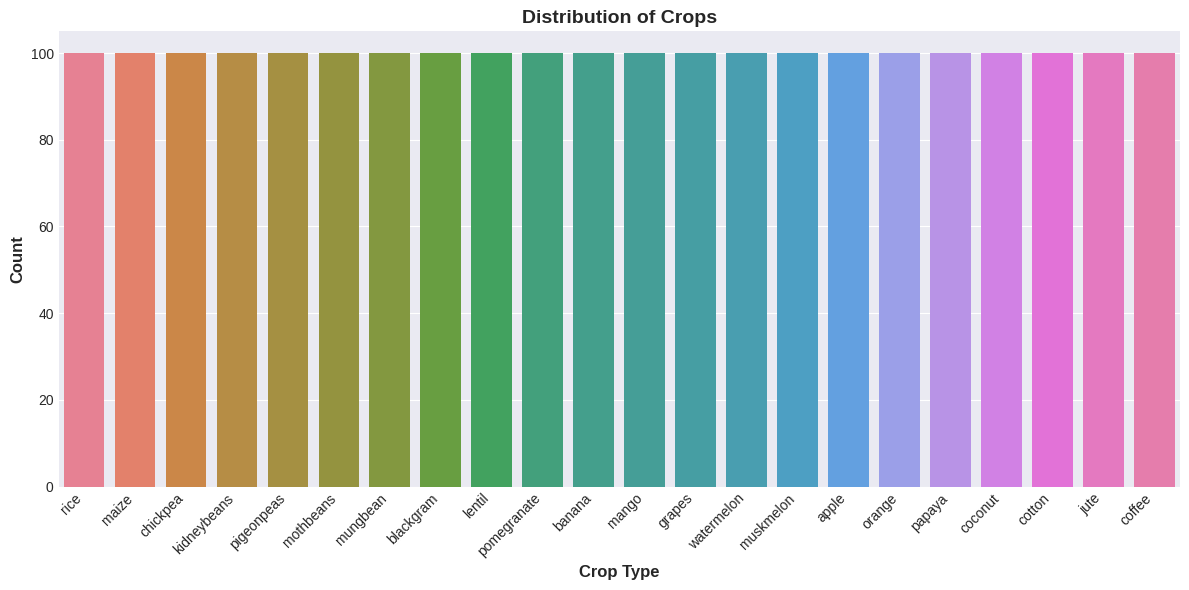

In [ ]:
# Target distribution
print("Target distribution")
print(df['label'].value_counts())

plt.figure(figsize=(12, 6))
label_counts = df['label'].value_counts()
sns.barplot(x=label_counts.index, y=label_counts.values, palette='husl')
plt.xlabel('Crop Type', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Distribution of Crops', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **Insight:** Dataset is well-balanced across all 22 crop types

Feature distributions


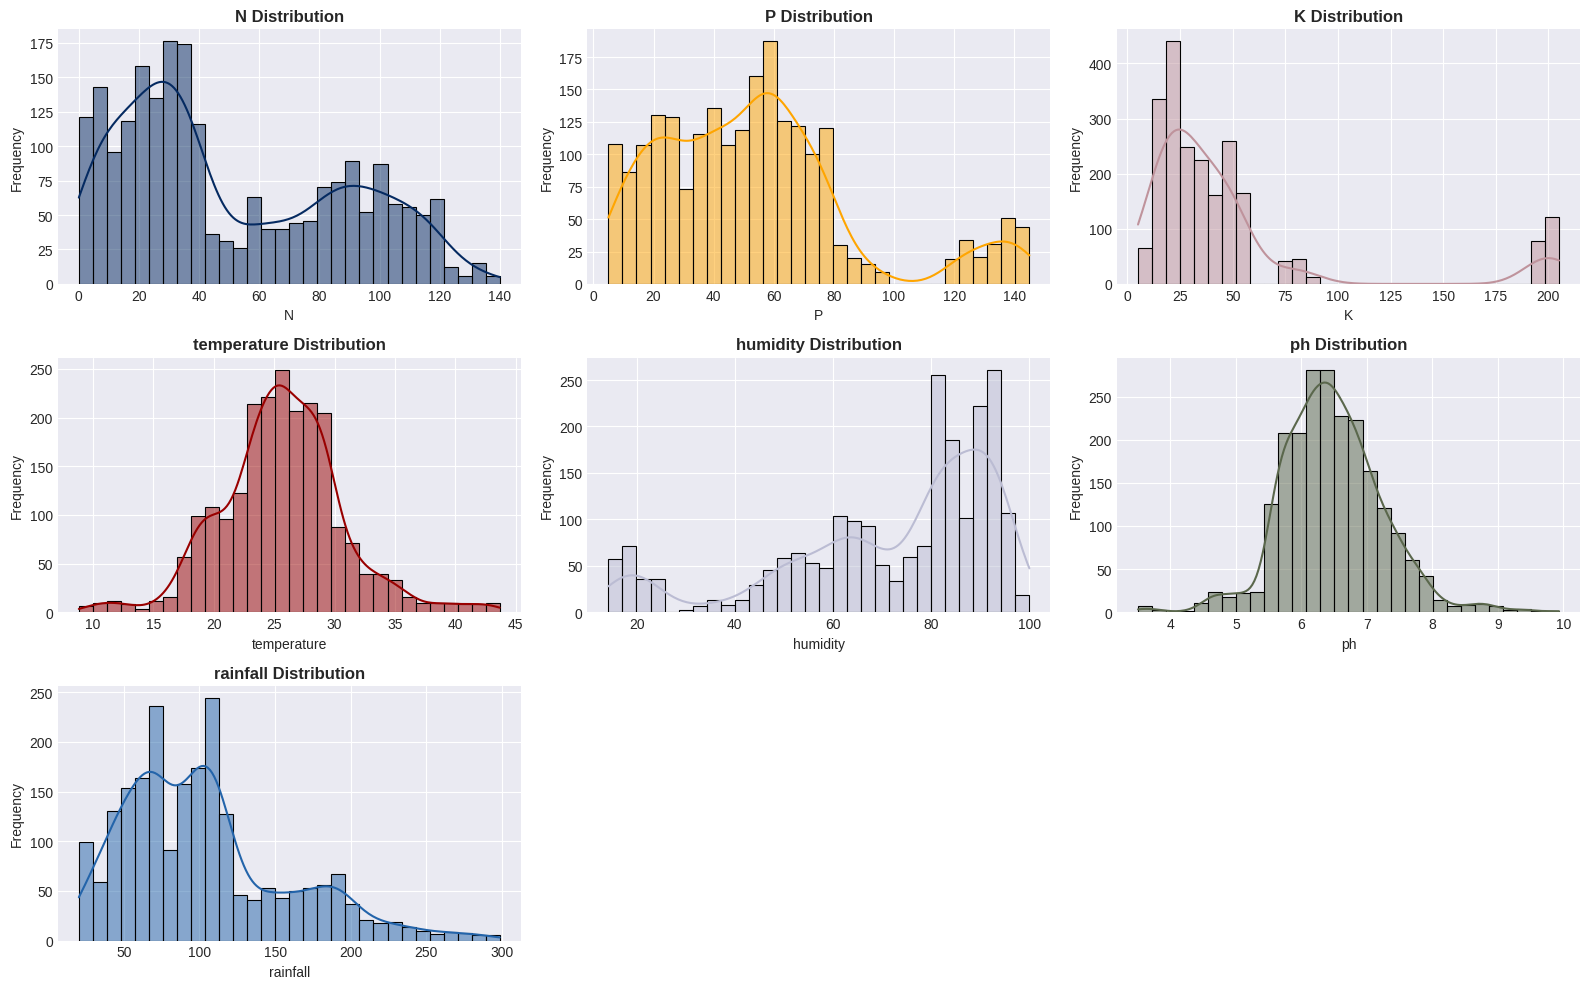

In [ ]:
# Feature distributions
print("Feature distributions")

num_features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
feature_colors = {
    'N': '#052A61', 'P': '#FFA500', 'K': '#bf939c',
    'temperature': '#990000', 'humidity': '#BBBCD3',
    'ph': '#5a674c', 'rainfall': '#2364AA'
}

plt.figure(figsize=(16, 10))
for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color=feature_colors[col])
    plt.title(f'{col} Distribution', fontweight='bold')
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### **Key Insights:**
- **Temperature:** Normally distributed (20-30°C)
- **Humidity:** Multi-modal distribution (varies by season/location)
- **pH:** Normally distributed (5.5-7.5, mostly neutral)
- **N & P:** Multi-modal distributions
- **K**: Right-skewed (most values 20-50)
- **Rainfall:** Right-skewed with some extreme values (not outliers, real weather)

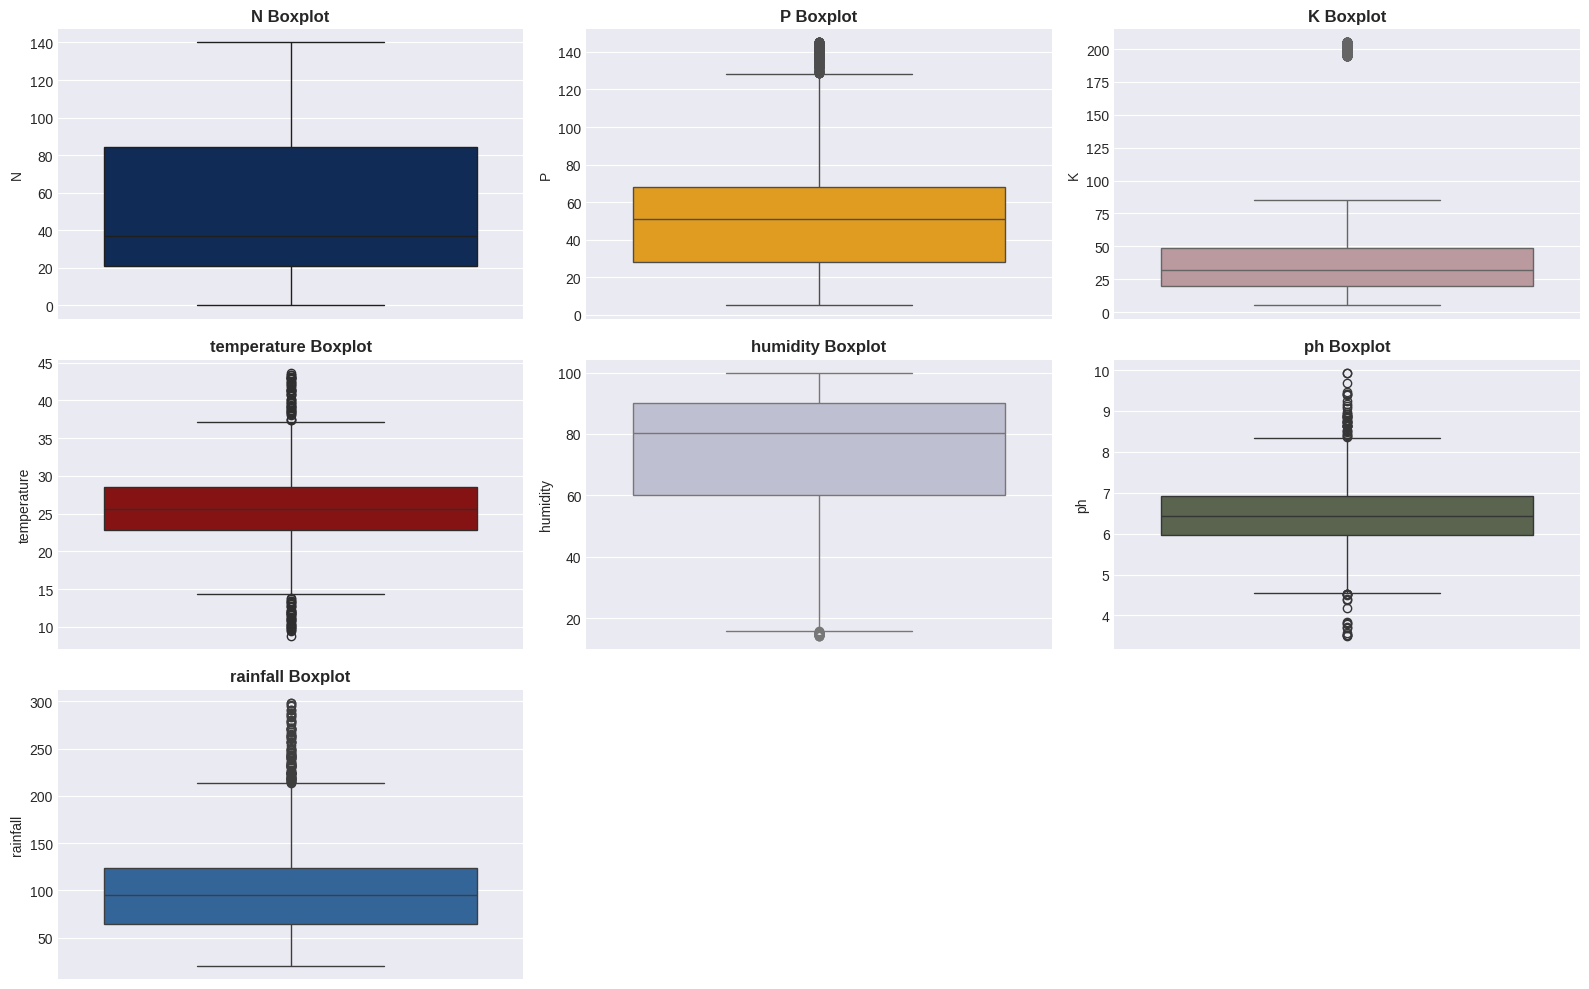

In [ ]:
# Box Plots for Outlier Detection
plt.figure(figsize=(16, 10))
for i, col in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col], color=feature_colors[col])
    plt.title(f'{col} Boxplot', fontweight='bold')
plt.tight_layout()
plt.show()

### **Insight:** Some extreme values represent real weather conditions

NPK Analysis by Crop


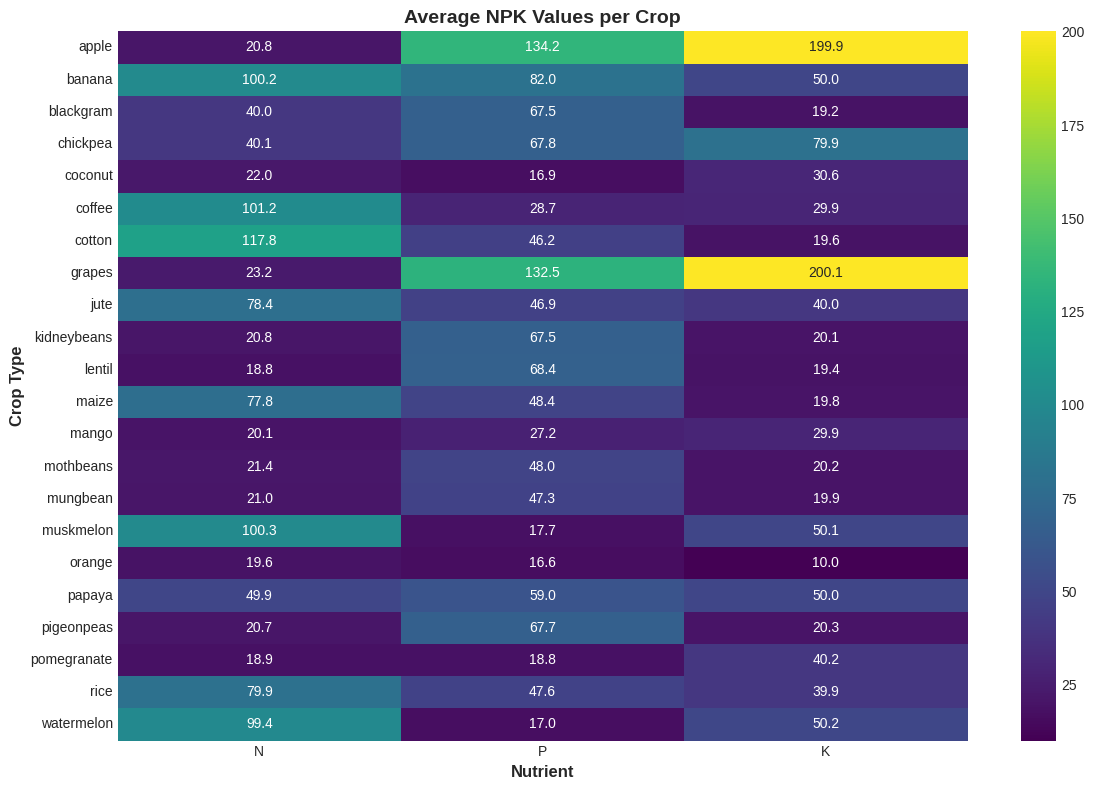

In [ ]:
# NPK Heatmap by Crop
print("NPK Analysis by Crop")

avg_npk = df.groupby("label")[['N', 'P', 'K']].mean()
plt.figure(figsize=(12, 8))
sns.heatmap(avg_npk, annot=True, cmap="viridis", fmt='.1f', cbar=True)
plt.title("Average NPK Values per Crop", fontsize=14, fontweight='bold')
plt.ylabel("Crop Type", fontsize=12, fontweight='bold')
plt.xlabel("Nutrient", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### **Insight:** Different crops have similar NPK requirements
Similar: apple & grapes, mothbeans & mungbeans, kidneybeans & lentil

<Figure size 1400x600 with 0 Axes>

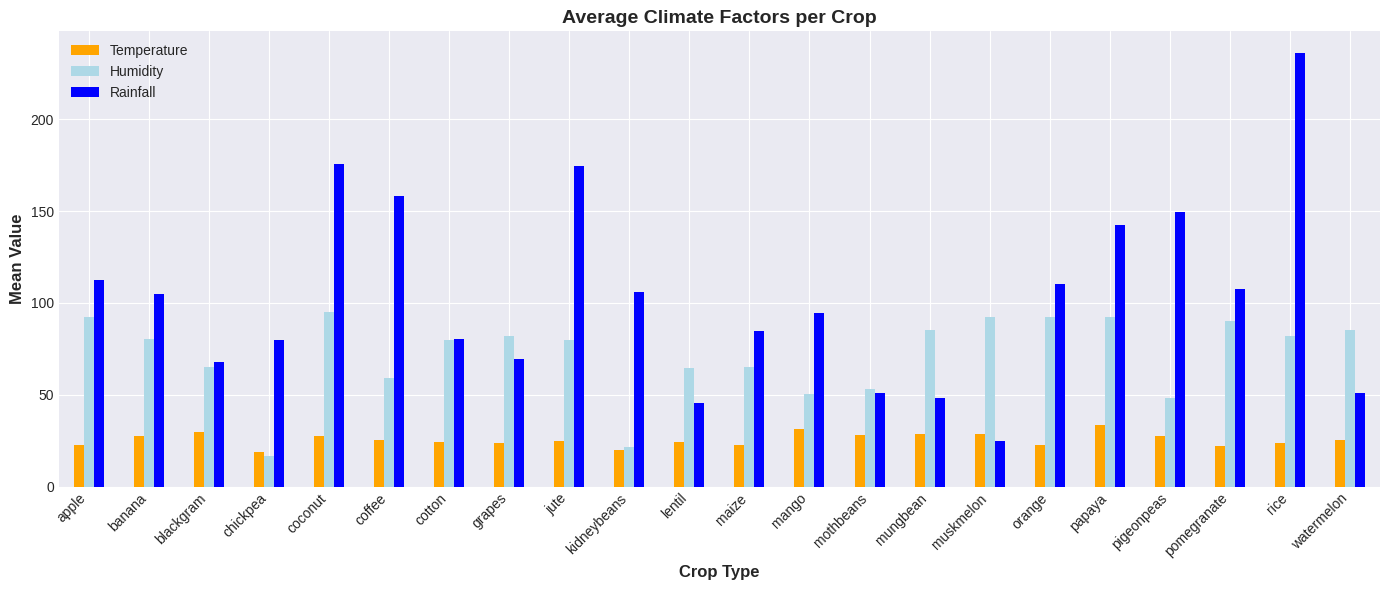

In [ ]:
# Climate Factors by Crop
plt.figure(figsize=(14, 6))
avg_climate = df.groupby("label")[['temperature', 'humidity', 'rainfall']].mean()
avg_climate.plot(kind="bar", figsize=(14, 6), color=['orange', 'lightblue', 'blue'])
plt.title("Average Climate Factors per Crop", fontsize=14, fontweight='bold')
plt.ylabel("Mean Value", fontsize=12, fontweight='bold')
plt.xlabel("Crop Type", fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(['Temperature', 'Humidity', 'Rainfall'])
plt.tight_layout()
plt.show()

### **Key Insights:**
- **Temperature:** Most crops (e.g., apple, banana) average 20-40°C, with jute and rice peaking near 100°C, indicating potential data anomalies or unique conditions.
- **Humidity:** Ranges 50-100% across crops, with apples and bananas at ~ 100%, favoring humid-tolerant crops like rice, while drier crops like cotton show lower values (~50%).
- **Rainfall:** Highly variable, from ~50 mm (lentil) to >200 mm (rice, pomegranate), suggesting rice and water-intensive crops thrive in high-rainfall areas, while others need irrigation.

**Crop Suitability:** High rainfall and humidity favor rice and pomegranate; moderate conditions suit apples, bananas, and grapes; low rainfall crops like lentil need drought-resistant strategies.

Feature Relationships


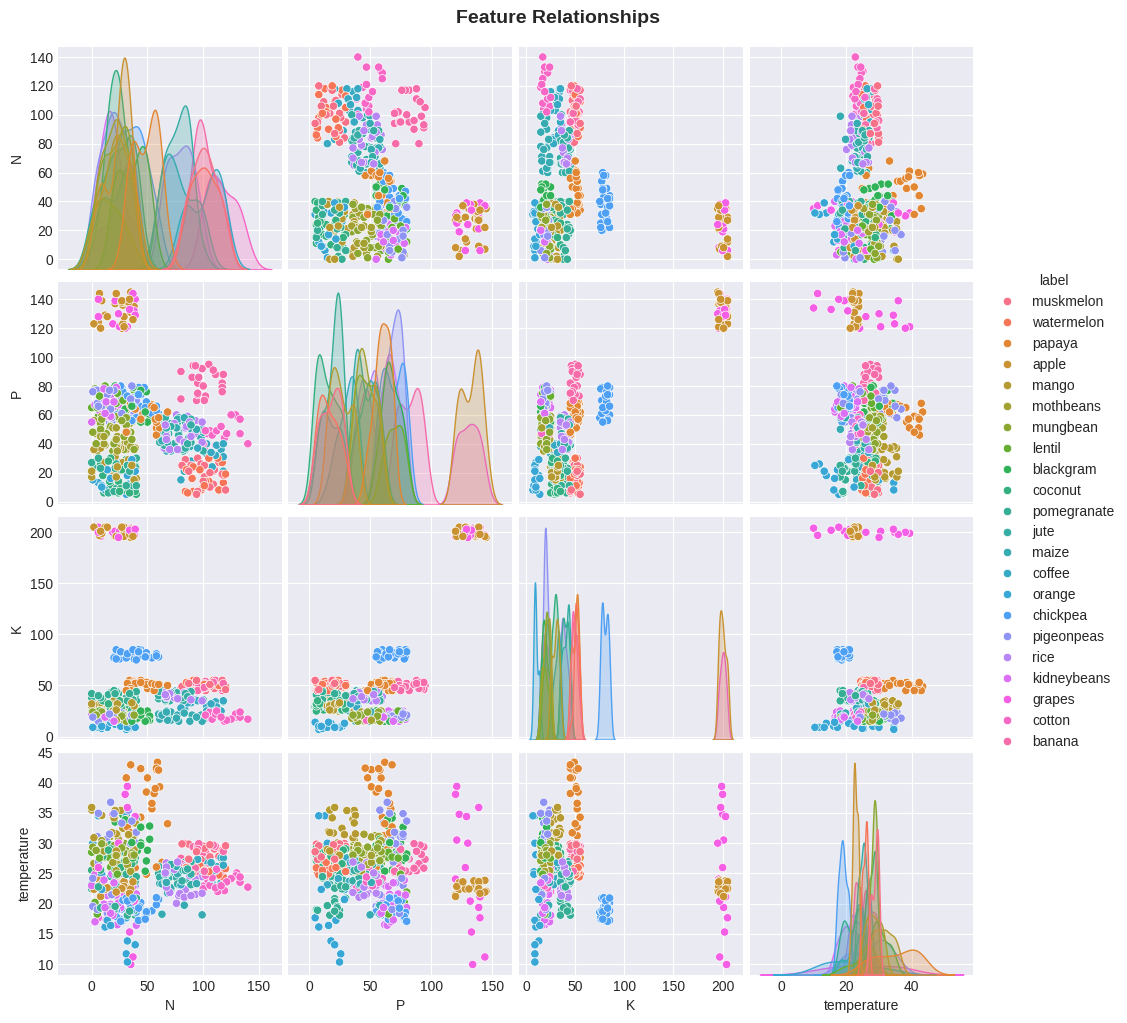

In [ ]:
# Pairplot (Sample)
print("Feature Relationships")

sample_df = df.sample(500, random_state=42)
sns.pairplot(sample_df,
             hue="label",
             vars=['N', 'P', 'K', 'temperature'],
             diag_kind='kde')
plt.suptitle("Feature Relationships", y=1.02, fontsize=14, fontweight='bold')
plt.show()

### **Insight:** Crops form distinct clusters based on nutrient and climate needs

# **Preprocessing**

## **Feature Engineering**

In [ ]:
# Create new features
df['NPK_Avg_Soil_Fertility'] = (df['N'] + df['P'] + df['K']) / 3
df['THI'] = (df['temperature'] * df['humidity']) / 100
df['NP_Ratio'] = df['N'] / df['P']
df['KP_Ratio'] = df['K'] / df['P']
df['temp_rain'] = df['temperature'] * df['rainfall']
df['ph_rain'] = df['ph'] * df['rainfall']

In [ ]:
# Categorical features
df['ph_category'] = df['ph'].apply(
    lambda x: 'Acidic' if x < 5.5 else ('Neutral' if x <= 7.5 else 'Alkaline')
)
df['rainfall_level'] = pd.cut(df['rainfall'],
                               bins=[0, 50, 100, 200, 300],
                               labels=['Low', 'Medium', 'High', 'Very High'])

Created 8 new features:
1. NPK_Avg_Soil_Fertility - Overall soil nutrient level
2. THI - Temperature-Humidity Index
3. NP_Ratio - Nitrogen to Phosphorus balance
4. KP_Ratio - Potassium to Phosphorus balance
5. temp_rain - Temperature × Rainfall interaction
6. ph_rain - pH × Rainfall interaction
7. ph_category - Acidic/Neutral/Alkaline
8. rainfall_level - Low/Medium/High/Very High

In [ ]:
print(f"New dataset shape: {df.shape}")
df.head()

New dataset shape: (2200, 16)


,N,P,K,temperature,humidity,ph,rainfall,label,NPK_Avg_Soil_Fertility,THI,NP_Ratio,KP_Ratio,temp_rain,ph_rain,ph_category,rainfall_level
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,58.333333,17.121963,2.142857,1.023810,4237.241986,1319.686807,Neutral,Very High
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,61.333333,17.485957,1.465517,0.706897,4934.395694,1595.223513,Neutral,Very High
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,53.000000,18.937446,1.090909,0.800000,6072.354751,2069.534380,Alkaline,Very High
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,49.666667,21.234829,2.114286,1.142857,6433.734530,1695.288324,Neutral,Very High
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,54.000000,16.427204,1.857143,1.000000,5288.545993,2004.132110,Alkaline,Very High


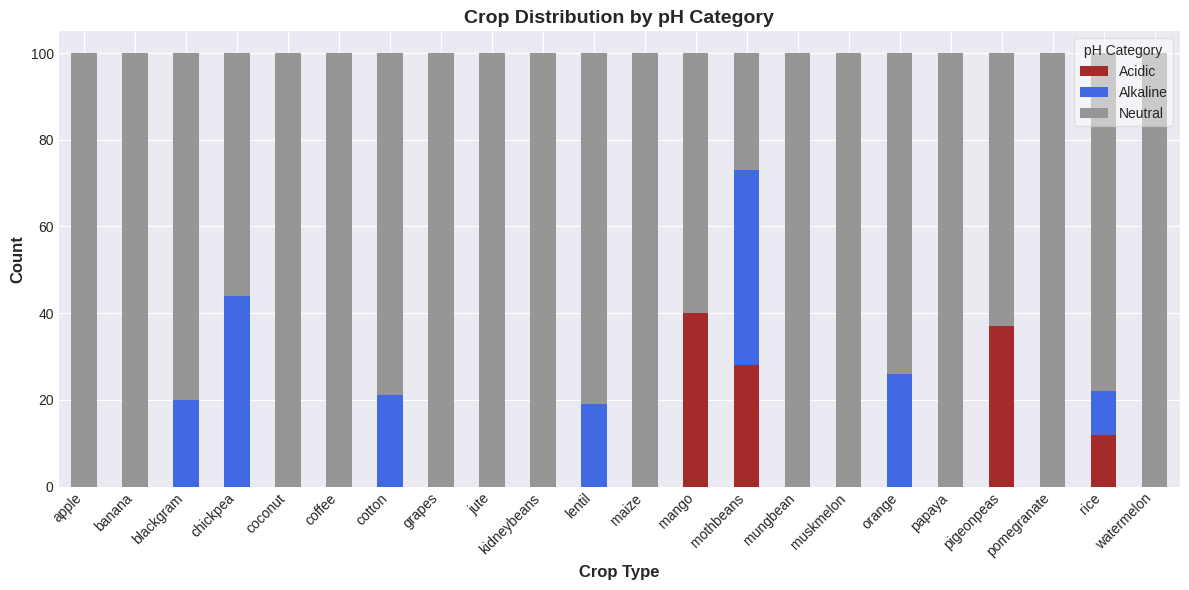

In [ ]:
# pH Category Analysis
label_ph = df.groupby(['label', 'ph_category']).size().unstack(fill_value=0)
colors_ph = {'Acidic': '#A52A2A', 'Neutral': '#969696', 'Alkaline': '#4169E1'}
label_ph.plot(kind='bar', stacked=True, figsize=(12, 6),
              color=[colors_ph[col] for col in label_ph.columns])
plt.xlabel('Crop Type', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Crop Distribution by pH Category', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.legend(title="pH Category", facecolor="white",framealpha=0.5, frameon=True)
plt.tight_layout()
plt.show()

### **Insight:** Most crops prefer neutral soil (pH 5.5-7.5)

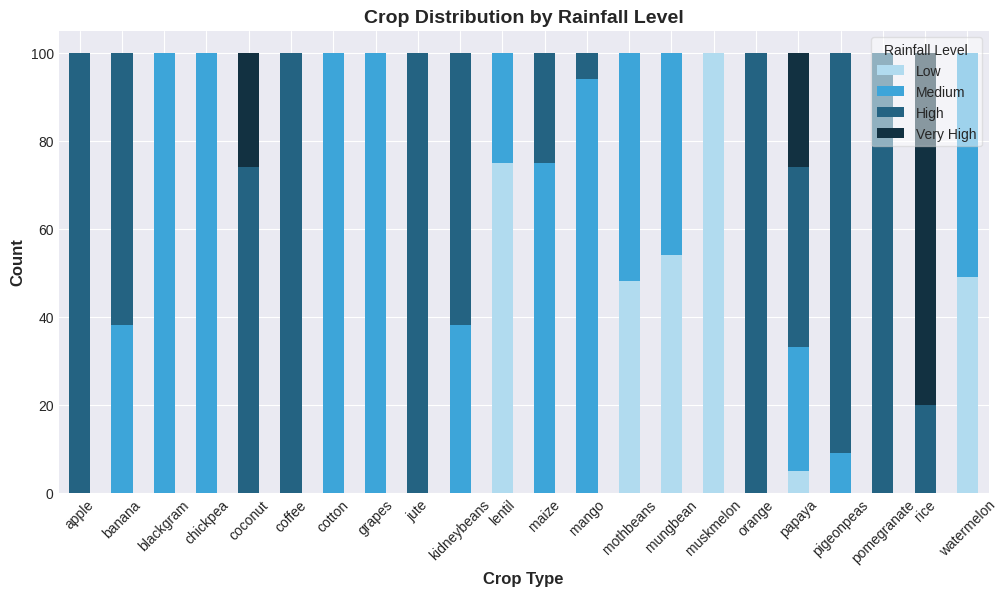

In [ ]:
# Rainfall Level Analysis
label_rain = df.groupby(['label', 'rainfall_level']).size().unstack(fill_value=0)

colors_rain = {'Low': '#b1dbef', 'Medium': '#3da5d9',
               'High': '#246382', 'Very High': '#123141'}

label_rain.plot(kind='bar', stacked=True, figsize=(12, 6),
                color=[colors_rain[col] for col in label_rain.columns])

plt.xlabel('Crop Type', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Crop Distribution by Rainfall Level', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.legend(title="Rainfall Level", loc='best', facecolor="white",framealpha=0.5, frameon=True)
plt.show()

### **Key Insights:**
- Rainfall is a strong predictor of crop type
- Some crops (apple, jute, orange) depend on high rainfall
- Others (papaya, banana) show high variability (less sensitive)

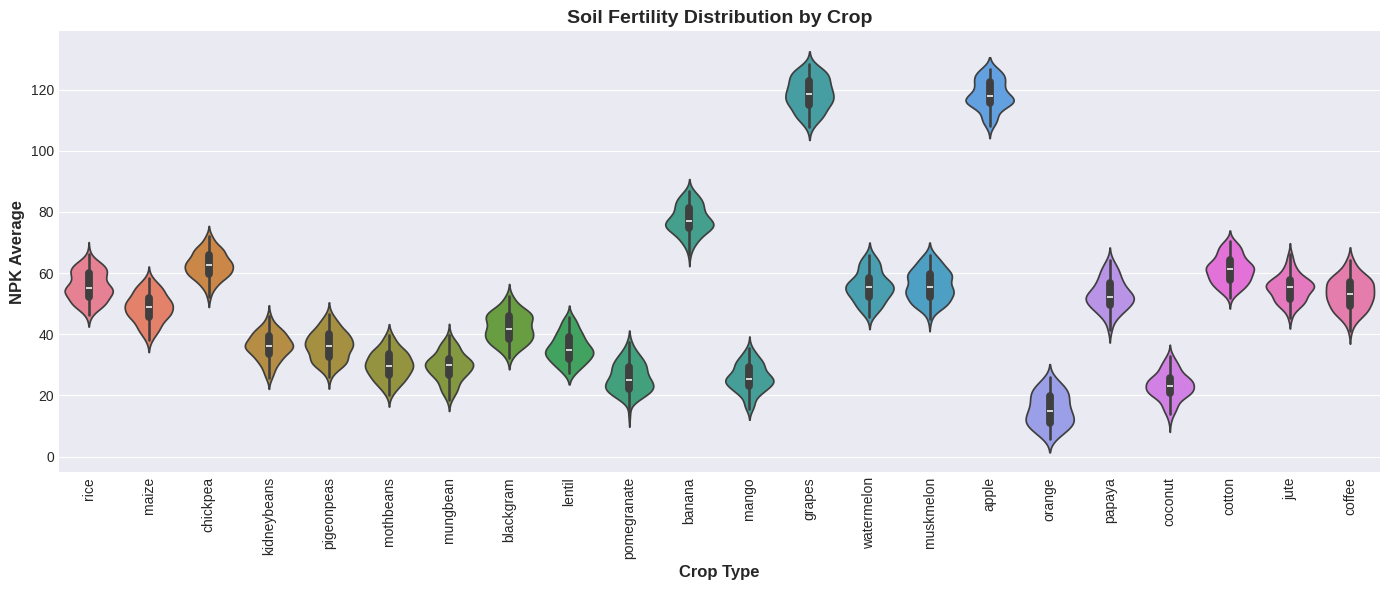

In [ ]:
# Soil Fertility Distribution
plt.figure(figsize=(14, 6))
sns.violinplot(x="label", y="NPK_Avg_Soil_Fertility",
               data=df, inner="box", palette='husl')
plt.xlabel('Crop Type', fontsize=12, fontweight='bold')
plt.ylabel('NPK Average', fontsize=12, fontweight='bold')
plt.title('Soil Fertility Distribution by Crop', fontsize=14, fontweight='bold')
plt.xticks(rotation=90)
plt.title("Soil Fertility Distribution by Crop", fontsize=14, fontweight='bold')
plt.xlabel('Crop Type', fontsize=12, fontweight='bold')
plt.ylabel('NPK Average', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

### **Key Insights:**
- Wide violins = crop tolerates diverse soil conditions
- Narrow violins = crop needs specific soil fertility

## **Encode Categorical Variables**

In [ ]:
# Encode: label, ph_category, rainfall_level
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df['ph_category'] = le.fit_transform(df['ph_category'])
df['rainfall_level'] = le.fit_transform(df['rainfall_level'])

df.head()

,N,P,K,temperature,humidity,ph,rainfall,label,NPK_Avg_Soil_Fertility,THI,NP_Ratio,KP_Ratio,temp_rain,ph_rain,ph_category,rainfall_level
0,90,42,43,20.879744,82.002744,6.502985,202.935536,20,58.333333,17.121963,2.142857,1.023810,4237.241986,1319.686807,2,3
1,85,58,41,21.770462,80.319644,7.038096,226.655537,20,61.333333,17.485957,1.465517,0.706897,4934.395694,1595.223513,2,3
2,60,55,44,23.004459,82.320763,7.840207,263.964248,20,53.000000,18.937446,1.090909,0.800000,6072.354751,2069.534380,1,3
3,74,35,40,26.491096,80.158363,6.980401,242.864034,20,49.666667,21.234829,2.114286,1.142857,6433.734530,1695.288324,2,3
4,78,42,42,20.130175,81.604873,7.628473,262.717340,20,54.000000,16.427204,1.857143,1.000000,5288.545993,2004.132110,1,3


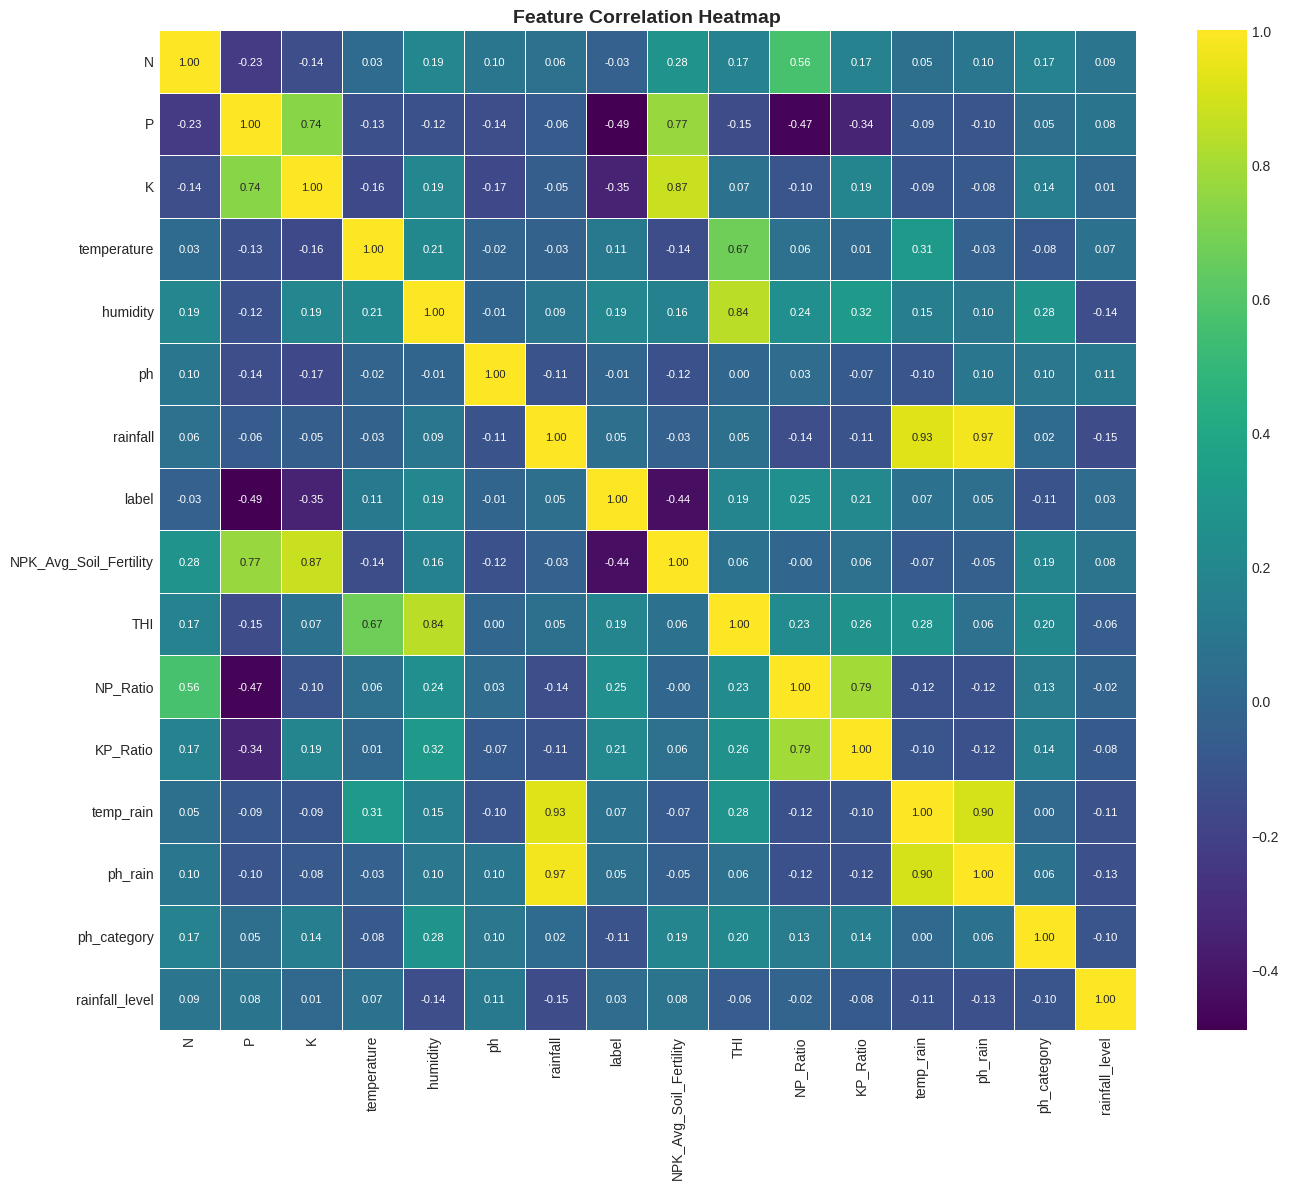

In [ ]:
# Correlation Analysis
plt.figure(figsize=(14, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f",
            annot_kws={"size": 8}, linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### **Insight:** Strong correlation between(NPK_Avg_Soil_Fertility, P, K) and the target.

## **Feature Selection**

In [ ]:
X = df.drop(['label'], axis=1)
y = df['label']

# Chi-Square Test
from sklearn.feature_selection import chi2, SelectKBest

selector = SelectKBest(score_func=chi2, k='all')
selector.fit(X, y)

chi2_scores = pd.DataFrame({
    "Feature": X.columns,
    "Chi2 Score": selector.scores_
}).sort_values(by="Chi2 Score", ascending=False)

print("Chi-Square Scores:")
print(chi2_scores.to_string(index=False))

Chi-Square Scores:
               Feature   Chi2 Score
             temp_rain 1.528748e+06
               ph_rain 3.457020e+05
                     K 1.167105e+05
              rainfall 5.480813e+04
                     N 5.314470e+04
                     P 4.250013e+04
NPK_Avg_Soil_Fertility 2.981838e+04
              humidity 1.475549e+04
              NP_Ratio 5.327409e+03
                   THI 4.706916e+03
              KP_Ratio 1.992507e+03
        rainfall_level 1.219287e+03
           temperature 1.092422e+03
           ph_category 1.053688e+02
                    ph 7.488657e+01


In [ ]:
# Select top 10 features based on Chi2
top_10_features = chi2_scores.head(10)['Feature'].tolist()

print("Top 10 Selected Features:")
for i, feat in enumerate(top_10_features, 1):
    score = chi2_scores[chi2_scores['Feature'] == feat]['Chi2 Score'].values[0]
    print(f"  {i}. {feat}: {score:.2e}")

Top 10 Selected Features:
  1. temp_rain: 1.53e+06
  2. ph_rain: 3.46e+05
  3. K: 1.17e+05
  4. rainfall: 5.48e+04
  5. N: 5.31e+04
  6. P: 4.25e+04
  7. NPK_Avg_Soil_Fertility: 2.98e+04
  8. humidity: 1.48e+04
  9. NP_Ratio: 5.33e+03
  10. THI: 4.71e+03


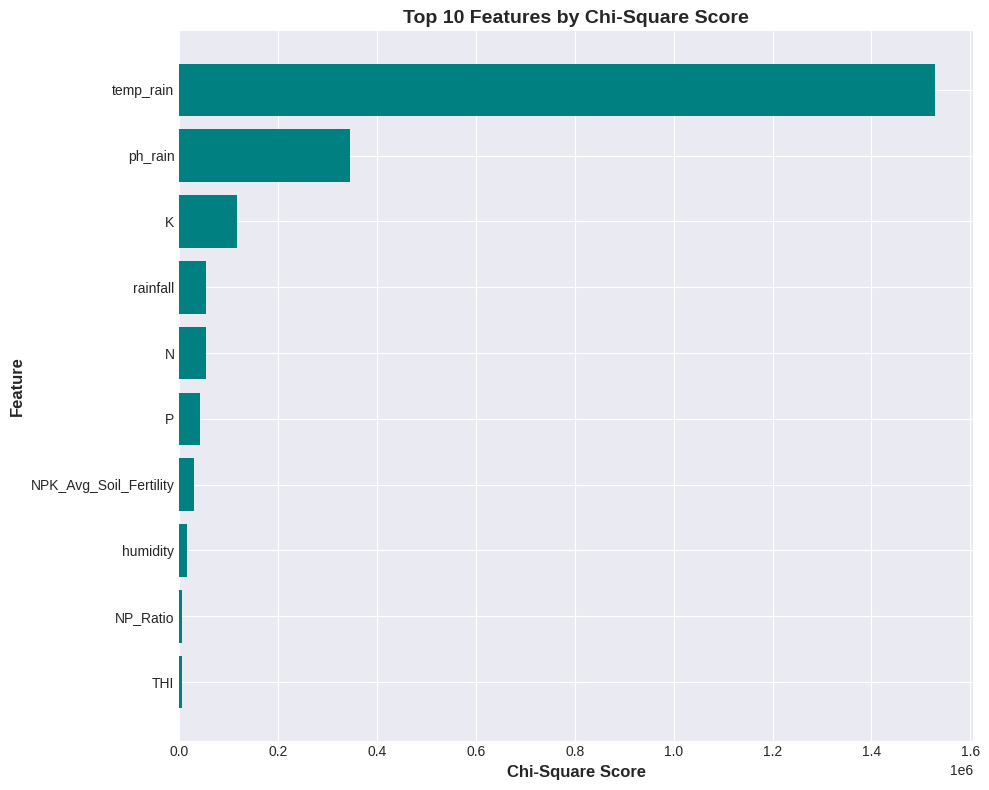

In [ ]:
# Visualize feature importance
plt.figure(figsize=(10, 8))
top_features = chi2_scores.head(10)
plt.barh(top_features['Feature'], top_features['Chi2 Score'], color='teal')
plt.xlabel('Chi-Square Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Top 10 Features by Chi-Square Score', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## **Prepare Data For Modeling**

In [ ]:
# Use top 10 features
X = df[top_10_features]
y = df['label']

In [ ]:
# Split data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (1540, 10)
Validation set: (330, 10)
Test set: (330, 10)


In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## **MlFlow with Dagshub**

In [ ]:
# Initialize DagsHub
dagshub.init(repo_owner='selvia.nasser19', repo_name='crop-recommendation', mlflow=True)
mlflow.set_experiment("crop_recommendation_models")

Initialized MLflow to track repo "selvia.nasser19/crop-recommendation"

Repository selvia.nasser19/crop-recommendation initialized!

<Experiment: artifact_location='mlflow-artifacts:/604aa7fb883140e1a734c685c909baa5', creation_time=1759182748678, experiment_id='1', last_update_time=1759182748678, lifecycle_stage='active', name='crop_recommendation_models', tags={}>

In [ ]:
# Define Models (RandomForest, XGBoost, SVM, DecisionTree)
models = {
    "RandomForest": {
        "model": RandomForestClassifier(
            n_estimators=200,
            max_depth=15,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ),
        "params": {
            "n_estimators": 200,
            "max_depth": 15,
            "min_samples_split": 5,
            "min_samples_leaf": 2
        }
    },
    "XGBoost": {
        "model": XGBClassifier(
            objective='multi:softmax',
            num_class=len(np.unique(y_train)),
            n_estimators=500,
            max_depth=10,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=1,
            random_state=42,
            n_jobs=-1,
            eval_metric='mlogloss'
        ),
        "params": {
            "n_estimators": 500,
            "max_depth": 10,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8
        }
    },
    "SVM": {
        "model": SVC(
            kernel="rbf",
            C=10,
            gamma='scale',
            probability=True,
            random_state=42
        ),
        "params": {
            "kernel": "rbf",
            "C": 10,
            "gamma": "scale"
        }
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(
            max_depth=20,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        ),
        "params": {
            "max_depth": 20,
            "min_samples_split": 5,
            "min_samples_leaf": 2
        }
    }
}



Training: RandomForest
Running 5-fold cross-validation...
CV Accuracy: 0.9877 (±0.0060)
CV F1-Score: 0.9876
Training on full training set...
Train Accuracy: 0.9994
Test Accuracy: 0.9970
Test F1-Score: 0.9970
Overfitting Gap: 0.0024


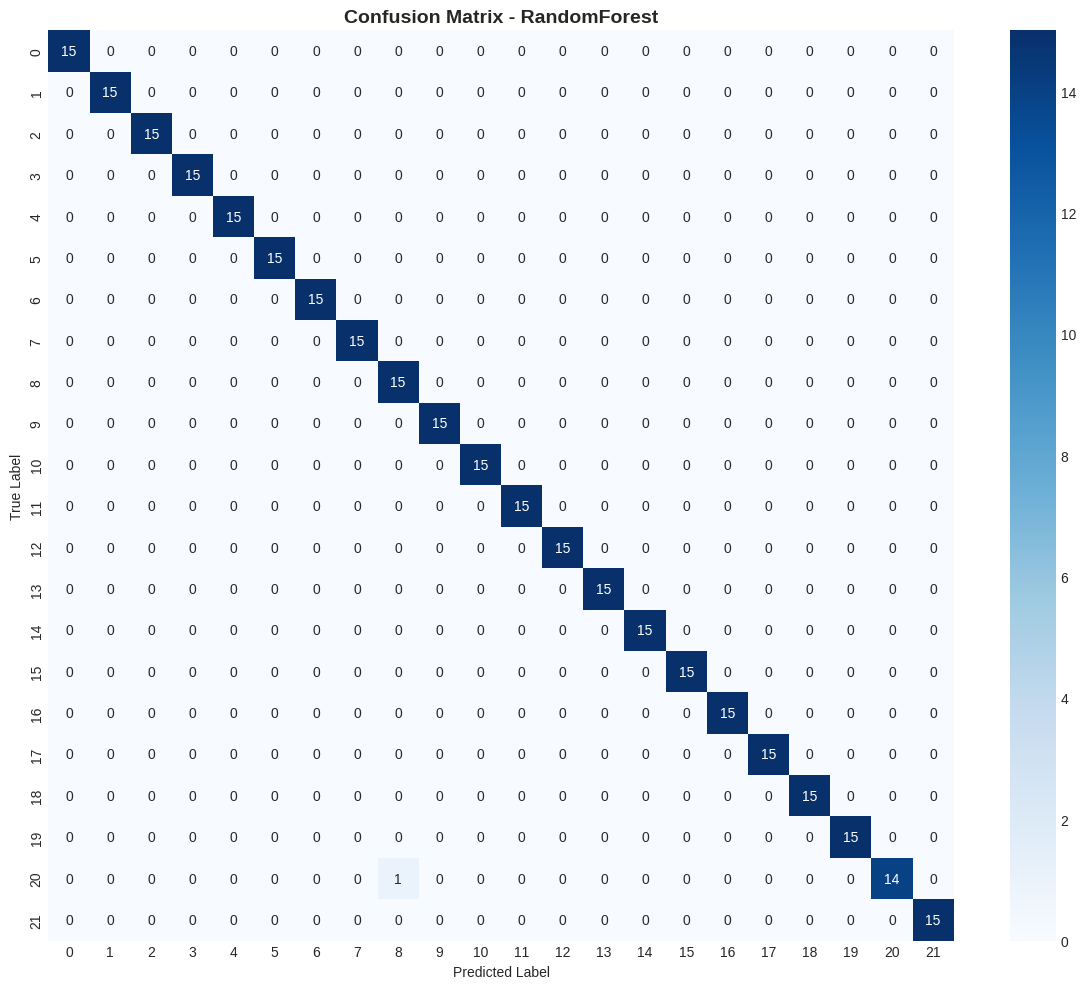


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       0.94      1.00      0.97        15
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
  

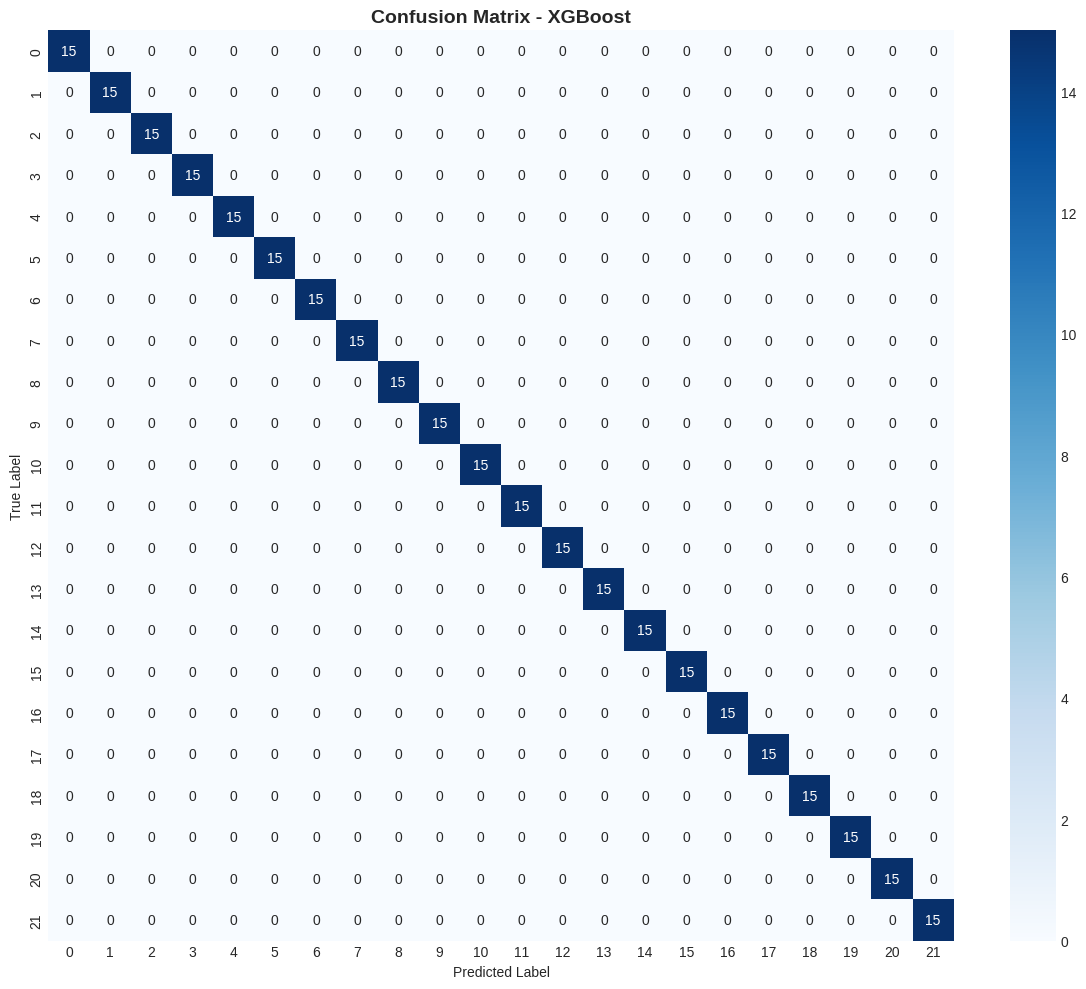


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
  

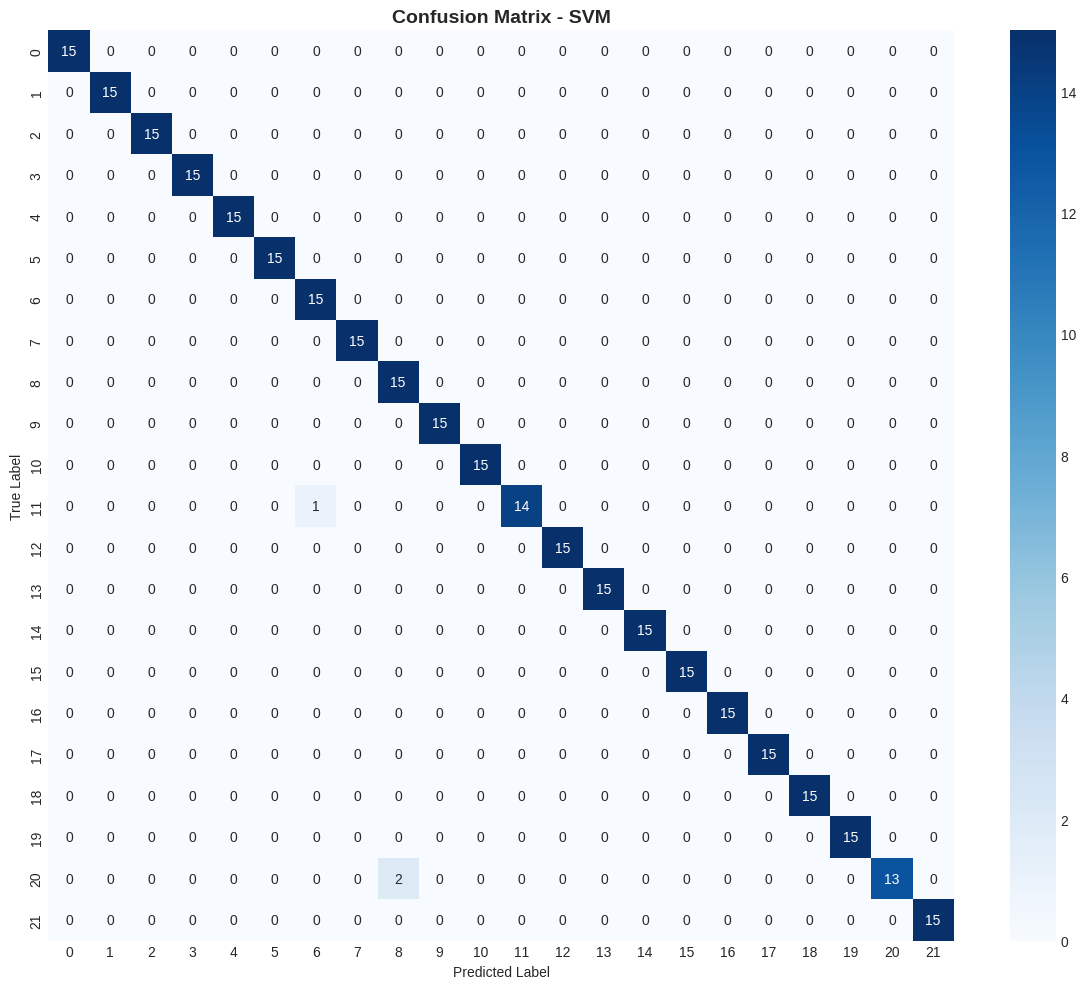


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       0.94      1.00      0.97        15
           7       1.00      1.00      1.00        15
           8       0.88      1.00      0.94        15
           9       1.00      1.00      1.00        15
          10       1.00      1.00      1.00        15
          11       1.00      0.93      0.97        15
          12       1.00      1.00      1.00        15
          13       1.00      1.00      1.00        15
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
  

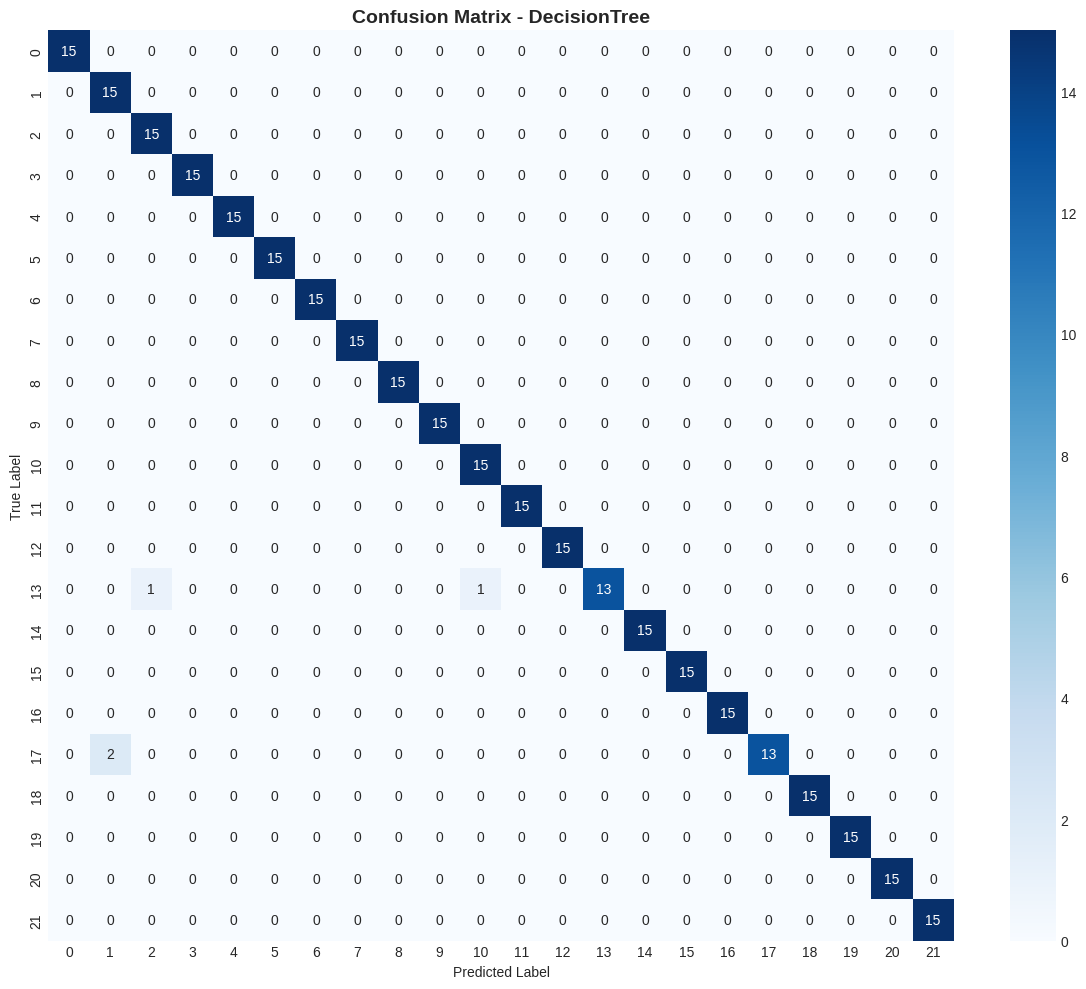


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.88      1.00      0.94        15
           2       0.94      1.00      0.97        15
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        15
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00        15
          10       0.94      1.00      0.97        15
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        15
          13       1.00      0.87      0.93        15
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
  

In [ ]:
# Train and Evaluate Models
results = []
trained_models = {}

for model_name, model_config in models.items():
    print(f"\n{'='*50}")
    print(f"\nTraining: {model_name}")

    # Start MLflow run
    with mlflow.start_run(run_name=model_name):

        # Log parameters
        mlflow.log_params(model_config['params'])
        mlflow.log_param("model_type", model_name)
        mlflow.log_param("n_features", X_train.shape[1])

        # Cross-validation
        print("Running 5-fold cross-validation...")
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_results = cross_validate(
            model_config['model'], X_train_scaled, y_train,
            cv=cv,
            scoring=['accuracy', 'f1_macro'],
            return_train_score=True,
            n_jobs=-1
        )

        cv_acc = cv_results['test_accuracy'].mean()
        cv_f1 = cv_results['test_f1_macro'].mean()

        print(f"CV Accuracy: {cv_acc:.4f} (±{cv_results['test_accuracy'].std():.4f})")
        print(f"CV F1-Score: {cv_f1:.4f}")

        # Train on full training set
        print("Training on full training set...")
        model_config['model'].fit(X_train_scaled, y_train)

        # Predictions
        y_train_pred = model_config['model'].predict(X_train_scaled)
        y_test_pred = model_config['model'].predict(X_test_scaled)

        # Calculate metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        test_acc = accuracy_score(y_test, y_test_pred)
        test_f1 = f1_score(y_test, y_test_pred, average='macro')
        test_precision = precision_score(y_test, y_test_pred, average='macro')
        test_recall = recall_score(y_test, y_test_pred, average='macro')

        print(f"Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        print(f"Test F1-Score: {test_f1:.4f}")
        print(f"Overfitting Gap: {train_acc - test_acc:.4f}")

        # Log metrics
        mlflow.log_metric("cv_accuracy", cv_acc)
        mlflow.log_metric("cv_f1", cv_f1)
        mlflow.log_metric("train_accuracy", train_acc)
        mlflow.log_metric("test_accuracy", test_acc)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("overfitting_gap", train_acc - test_acc)

        # Confusion matrix
        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{model_name}.png', dpi=300)
        mlflow.log_artifact(f'confusion_matrix_{model_name}.png')
        plt.show()

        # Classification report
        print(f"\nClassification Report:\n")
        print(classification_report(y_test, y_test_pred))

        # Store results
        results.append({
            'Model': model_name,
            'CV_Accuracy': cv_acc,
            'Train_Accuracy': train_acc,
            'Test_Accuracy': test_acc,
            'Test_F1': test_f1,
            'Overfitting_Gap': train_acc - test_acc
        })

        trained_models[model_name] = model_config['model']


       Model  CV_Accuracy  Train_Accuracy  Test_Accuracy  Test_F1  Overfitting_Gap
     XGBoost     0.988312        1.000000       1.000000 1.000000         0.000000
RandomForest     0.987662        0.999351       0.996970 0.996966         0.002381
         SVM     0.981169        0.989610       0.990909 0.990879        -0.001299
DecisionTree     0.972727        0.996104       0.987879 0.987733         0.008225

Best Model: XGBoost
Test Accuracy: 1.0000


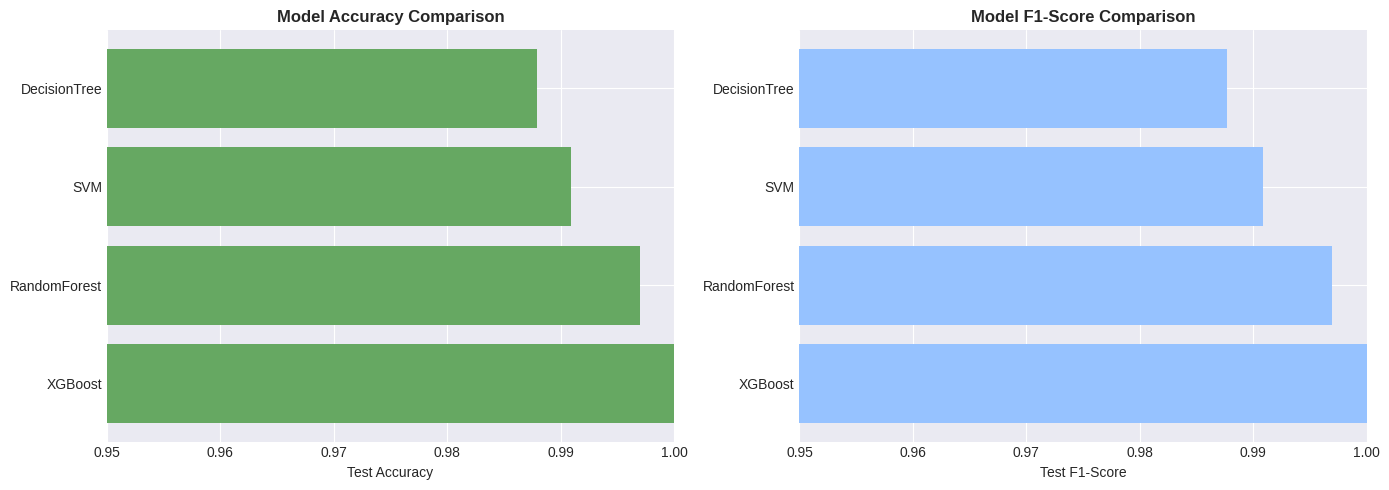

In [ ]:
# Compare Results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Test_Accuracy', ascending=False)
print(results_df.to_string(index=False))

# Best model
best_model_name = results_df.iloc[0]['Model']
print(f"\nBest Model: {best_model_name}")
print(f"Test Accuracy: {results_df.iloc[0]['Test_Accuracy']:.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].barh(results_df['Model'], results_df['Test_Accuracy'], color='#66A862')
axes[0].set_xlabel('Test Accuracy')
axes[0].set_title('Model Accuracy Comparison', fontweight='bold')
axes[0].set_xlim([0.95, 1.0])

# F1-Score
axes[1].barh(results_df['Model'], results_df['Test_F1'], color='#96C2FF')
axes[1].set_xlabel('Test F1-Score')
axes[1].set_title('Model F1-Score Comparison', fontweight='bold')
axes[1].set_xlim([0.95, 1.0])

plt.tight_layout()
plt.show()

## **Conclusion:**

- No serious overfitting across models.

- The Decision Tree shows the largest gap (~0.8%), but that’s still very small.

- XGBoost is the best model here: CV, train, and test all align perfectly.

- The dataset might be relatively "easy" or well-structured (features strongly separate classes), which is why models hit near-perfect accuracy.

In [ ]:
print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {results_df.iloc[0]['Test_Accuracy']*100:.2f}%")

Best Model: XGBoost
Test Accuracy: 100.00%


**Ready for deployment!**

View experiments at: https://dagshub.com/selvia.nasser19/crop-recommendation